In [1]:
!pip install google-cloud-storage tensorflow --quiet

In [2]:
import os
import json
from datetime import datetime as dt
from multiprocessing import Pool

import numpy as np

import itertools
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer
from skimage.io import imread

from google.cloud import storage

import tensorflow as tf
from tensorflow.keras.applications import vgg16
from tensorflow.python.lib.io import file_io
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelBinarizer

import _pickle as pickle

In [3]:
dataset_id = '20181202_163223'
train_id = '20181202_173509'

In [4]:
basepath = 'gs://bigdata-allanbatista-com-br/image-classifier/{}/'.format(dataset_id)
model_path = '{}train/{}/model.hdf5'.format(basepath, train_id)

In [5]:
gs = storage.Client()
bucket = gs.bucket('bigdata-allanbatista-com-br')

In [6]:
with file_io.FileIO('{}binarizer.pickle'.format(basepath), 'rb') as f:
    binarizer = pickle.loads(f.read())

In [7]:
with file_io.FileIO(model_path, 'rb') as f:
    with open('model.hdf5', 'wb') as ff:
        ff.write(f.read())

model = load_model('model.hdf5')

In [8]:
def _parse_example(serialized_example):
    feature_set = {
        'label': tf.FixedLenSequenceFeature([], tf.int64, allow_missing=True),
        'features': tf.FixedLenFeature([], tf.string)
    }

    parsed = tf.parse_single_example(serialized_example, features=feature_set)

    return tf.decode_raw(parsed['features'], tf.float32), parsed['label']


def create_dataset(files, batch_size=16, epochs=1):
    print("build_tfrecord: files_count: {} / batch_size: {} / epochs: {}".format(len(files), batch_size, epochs))

    ds = tf.data.TFRecordDataset(files)
    ds = ds.map(_parse_example)
    ds = ds.batch(batch_size)
    ds = ds.repeat(epochs)
    ds = ds.prefetch(tf.contrib.data.AUTOTUNE)

    return ds


def blobs_names_with_bucket(bucket_name, pattern):
    return ["gs://%s/%s" % (bucket_name, i.name) for i in bucket.list_blobs(prefix=pattern)]


def create_dataset_form_pattern(bucket_name, pattern, batch_size=16, epochs=1):
    return create_dataset(blobs_names_with_bucket(bucket_name, pattern), batch_size, epochs)

dataset = create_dataset_form_pattern('bigdata-allanbatista-com-br',
                                      'image-classifier/{}/testset/'.format(dataset_id),
                                      batch_size=16,
                                      epochs=1)

iterator = dataset.make_one_shot_iterator()
a = iterator.get_next()

x_test = []
y_true = []
count = 0

with tf.Session() as sess:
    for i in range(1271 // 16):
        x, y = sess.run([a])[0]
        y_true += binarizer.inverse_transform(y).tolist()
        x_test.append(x)
        count += 1
        if count % 10 == 0:
            print(count)

build_tfrecord: files_count: 13 / batch_size: 16 / epochs: 1
10
20
30
40
50
60
70


In [9]:
x_test_predictions = []
for batch in x_test:
    x_test_predictions += [binarizer.classes_[index] for index in model.predict_classes(batch)]

In [10]:
print(classification_report(y_true, x_test_predictions))

             precision    recall  f1-score   support

   bluebell       0.00      0.00      0.00        31
  buttercup       0.54      0.12      0.20        58
  coltsfoot       0.50      0.02      0.04       141
    cowslip       0.00      0.00      0.00        33
     crocus       0.00      0.00      0.00        46
   daffodil       0.00      0.00      0.00        66
      daisy       0.71      0.19      0.29        54
  dandelion       0.58      0.32      0.41        81
 fritillary       0.14      0.03      0.04       113
       iris       0.29      0.02      0.04        83
lily_valley       0.42      0.22      0.29        85
      pansy       0.36      0.09      0.15       149
   snowdrop       0.37      0.34      0.35        65
  sunflower       0.17      0.55      0.26        73
  tigerlily       0.14      0.89      0.24       118
      tulip       0.00      0.00      0.00        46
 windflower       0.00      0.00      0.00        22

avg / total       0.29      0.20      0.15  

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [11]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Normalized confusion matrix


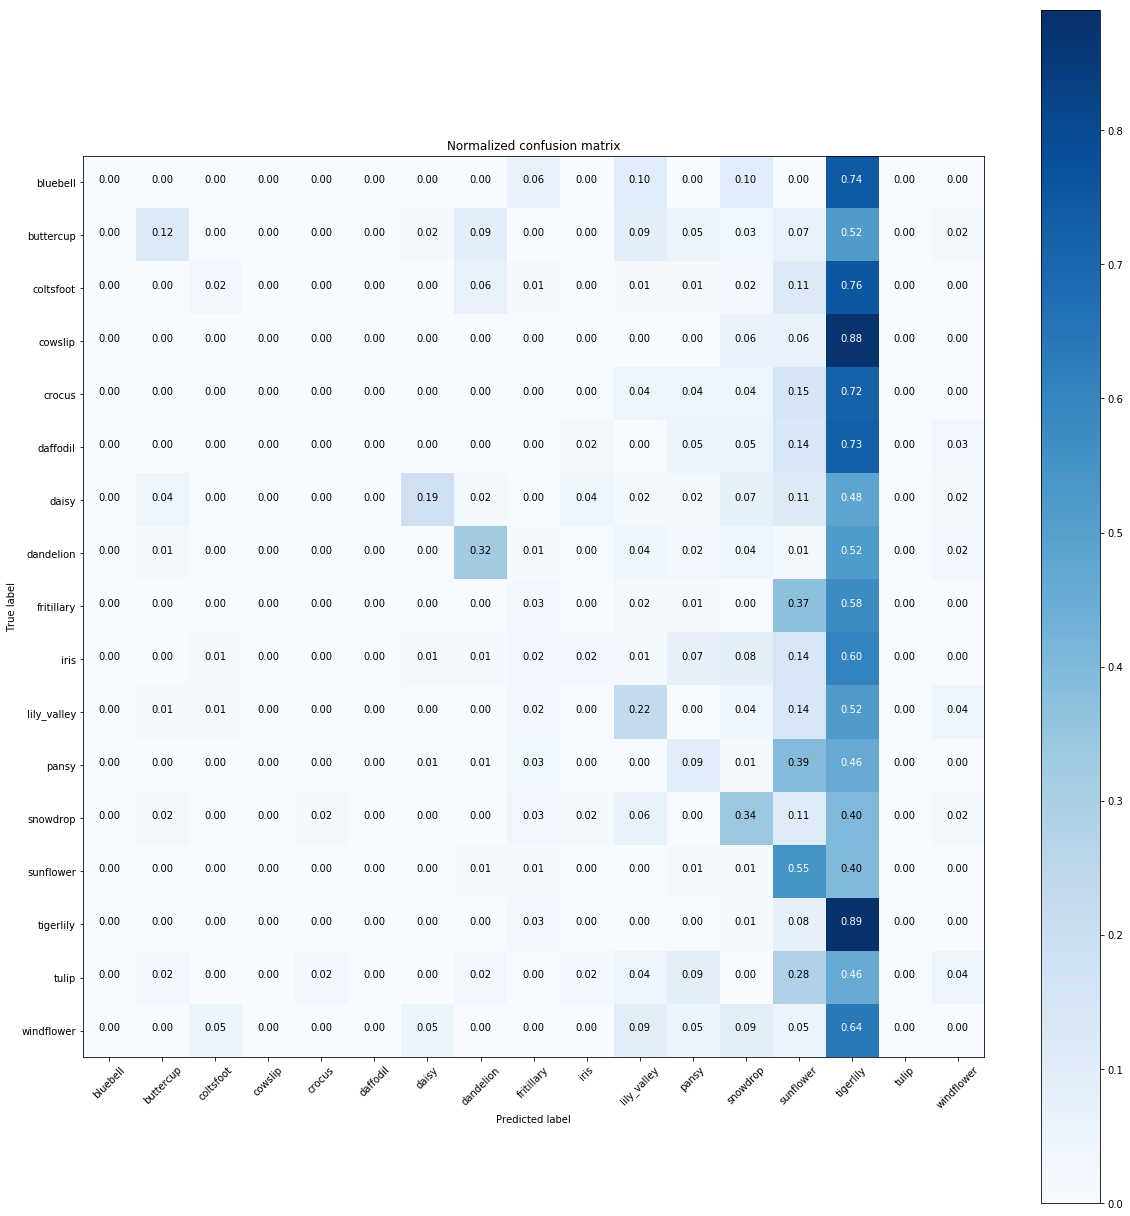

In [12]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_true, x_test_predictions)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure(figsize=(len(binarizer.classes_), len(binarizer.classes_)))
plot_confusion_matrix(cnf_matrix, classes=binarizer.classes_, normalize=True,
                      title='Normalized confusion matrix')

plt.show()